In [1]:
from __future__ import print_function
import sys
import os
import pandas as pd
import csv
import seaborn as sns
import time
import matplotlib.pyplot as plt
import alphastats
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") # remove warning from mac
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook" 
from IPython.display import display, HTML, Markdown
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads, _openmp_parallelism_enabled
_openmp_effective_n_threads(6)

plt.rcParams['pdf.fonttype'] = 42 

os.environ.setdefault("TF_NUM_THREADS", "10")
os.environ.setdefault("TF_LOOP_PARALLEL_ITERATIONS", "10")

/Users/magalhae/miniforge3/envs/alphastats/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


'10'

In [2]:
import plotly

colorway=["#B80000", "#E81E63", "#8D239E", "#673AB7", "#3F51B5", "#253985", "#02A8F4", "#009688", "#8BC34A", "#FF9800", "#FE5622", "#795648", "#9E9E9E", "#617D8B",]

plotly.io.templates["alphastats_colors"] = plotly.graph_objects.layout.Template(
    layout=plotly.graph_objects.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        colorway=colorway
        ,
    )
)
plotly.io.templates.default = "simple_white+alphastats_colors"

display(Markdown('<br>'.join(
    f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
    for color in colorway
)))
len(colorway)

<span style="font-family: monospace">#B80000 <span style="color: #B80000">████████</span></span><br><span style="font-family: monospace">#E81E63 <span style="color: #E81E63">████████</span></span><br><span style="font-family: monospace">#8D239E <span style="color: #8D239E">████████</span></span><br><span style="font-family: monospace">#673AB7 <span style="color: #673AB7">████████</span></span><br><span style="font-family: monospace">#3F51B5 <span style="color: #3F51B5">████████</span></span><br><span style="font-family: monospace">#253985 <span style="color: #253985">████████</span></span><br><span style="font-family: monospace">#02A8F4 <span style="color: #02A8F4">████████</span></span><br><span style="font-family: monospace">#009688 <span style="color: #009688">████████</span></span><br><span style="font-family: monospace">#8BC34A <span style="color: #8BC34A">████████</span></span><br><span style="font-family: monospace">#FF9800 <span style="color: #FF9800">████████</span></span><br><span style="font-family: monospace">#FE5622 <span style="color: #FE5622">████████</span></span><br><span style="font-family: monospace">#795648 <span style="color: #795648">████████</span></span><br><span style="font-family: monospace">#9E9E9E <span style="color: #9E9E9E">████████</span></span><br><span style="font-family: monospace">#617D8B <span style="color: #617D8B">████████</span></span>

14

In [3]:
Andersen2005 = pd.read_csv('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/Andersen2005_idmapping_active_true_2024_08_28.tsv',low_memory=False, sep = '\t')
SubCellBarcode = pd.read_csv('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/SubCell_markerProteins_annotated.csv',low_memory=False)
Stenstrom2020 = pd.read_excel('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/msb209469-sup-0002-datasetev1.xlsx', sheet_name=1)
Stenstrom2020 = Stenstrom2020[~Stenstrom2020['Uniprot ID'].isna()]
Andersen2005.info()
SubCellBarcode.info()
Stenstrom2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   From                                810 non-null    object
 1   Entry                               810 non-null    object
 2   Reviewed                            810 non-null    object
 3   Entry Name                          810 non-null    object
 4   Protein names                       810 non-null    object
 5   Gene Names                          796 non-null    object
 6   GeneID                              787 non-null    object
 7   Ensembl                             765 non-null    object
 8   Gene Ontology (molecular function)  781 non-null    object
 9   Gene Ontology (biological process)  777 non-null    object
 10  Gene Ontology (cellular component)  800 non-null    object
dtypes: object(11)
memory usage: 69.7+ KB
<class 'pandas.core.f

In [4]:
ProteinGroups = pd.read_csv('/Users/magalhae/Desktop/FANCY_proteome/FANCY_NPM1_20241206/txt/proteinGroups.txt',low_memory=False, sep = '\t')
# ProteinGroups = ProteinGroups.set_index('Protein IDs')
ProteinGroups.info()
ProteinGroups = ProteinGroups[~ProteinGroups['Protein IDs'].str.contains("CON_")]
ProteinGroups = ProteinGroups[~ProteinGroups['Protein IDs'].str.contains("REV__")]
ProteinGroups.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002 entries, 0 to 4001
Columns: 474 entries, Protein IDs to Taxonomy names
dtypes: float64(202), int64(201), object(71)
memory usage: 14.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 3813 entries, 0 to 3945
Columns: 474 entries, Protein IDs to Taxonomy names
dtypes: float64(202), int64(201), object(71)
memory usage: 13.8+ MB


In [5]:
maxquant_data = alphastats.MaxQuantLoader(ProteinGroups)
# maxquant_data = alphastats.MaxQuantLoader(file="proteinGroups.txt")
ds = alphastats.DataSet(
    loader = maxquant_data, 
    metadata_path="Metadata.csv", 
    sample_column="sample"
)
print(f"Number of samples in the matrix: {ds.mat.shape[0]}, number of samples in metadata: {ds.metadata.shape[0]}.")

DataSet has been created.
Attributes of the DataSet can be accessed using: 
DataSet.rawinput:	 Raw Protein data.
DataSet.mat:		Processed data matrix with ProteinIDs/ProteinGroups as columns and samples as rows. All computations are performed on this matrix.
DataSet.metadata:	Metadata for the samples in the matrix. Metadata will be matched with DataSet.mat when needed (for instance Volcano Plot).
Number of samples in the matrix: 48, number of samples in metadata: 34.


In [6]:
ds.mat.replace(0, np.nan, inplace=True)

In [7]:
#ds.preprocess(subset = True, log2_transform =False,remove_contaminations=True)
ds.preprocess(subset = True, log2_transform =True)

Data has been log2-transformed.


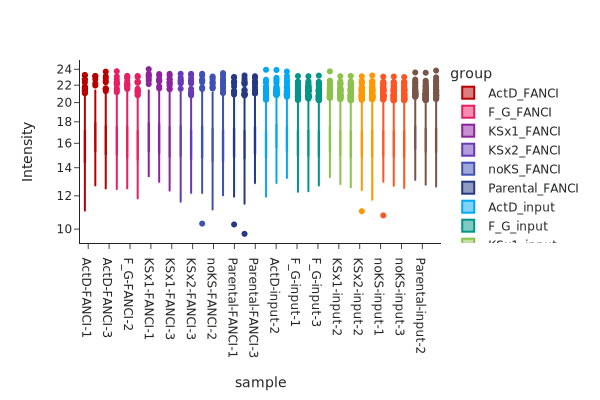

In [8]:
plot = ds.plot_sampledistribution(method = "box", color = "group", log_scale = True)
plot.show(renderer = "svg", width=600, height=400)
plot.write_image("sampledistribution.pdf")

In [9]:
ds.preprocess_print_info()

                                                    0  \
0                   Raw data number of Protein Groups   
1          Matrix: Number of ProteinIDs/ProteinGroups   
2                           Matrix: Number of samples   
3                         Intensity used for analysis   
4                                    Log2-transformed   
5                                       Normalization   
6                                          Imputation   
7                    Contaminations have been removed   
8                               Contamination columns   
9   Number of removed ProteinGroups due to contami...   
10                          Data completeness cut-off   

                                                    1  
0                                                2963  
1                                                2963  
2                                                  34  
3                              LFQ intensity [sample]  
4                                  

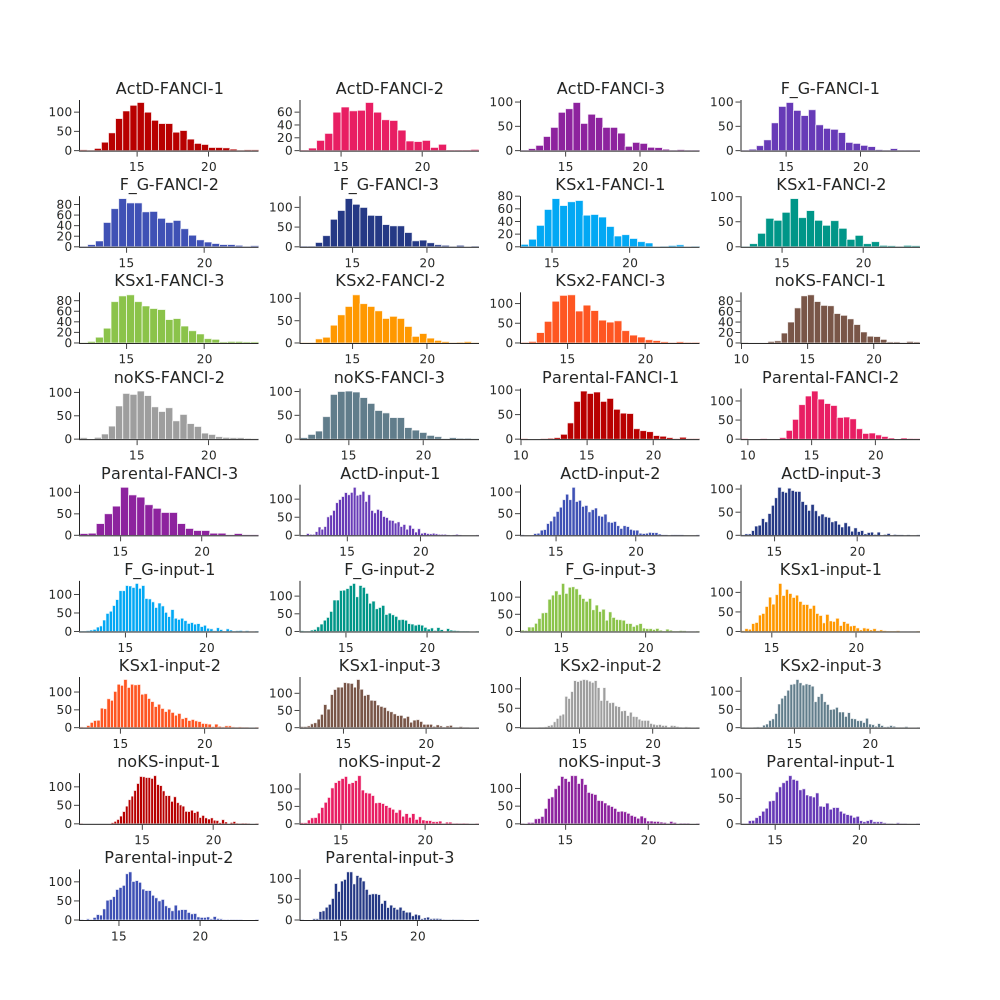

In [10]:
plot = ds.plot_samplehistograms()
plot.show(renderer = "svg", width=1000, height=1000)
plot.write_image("samplehistograms.pdf")

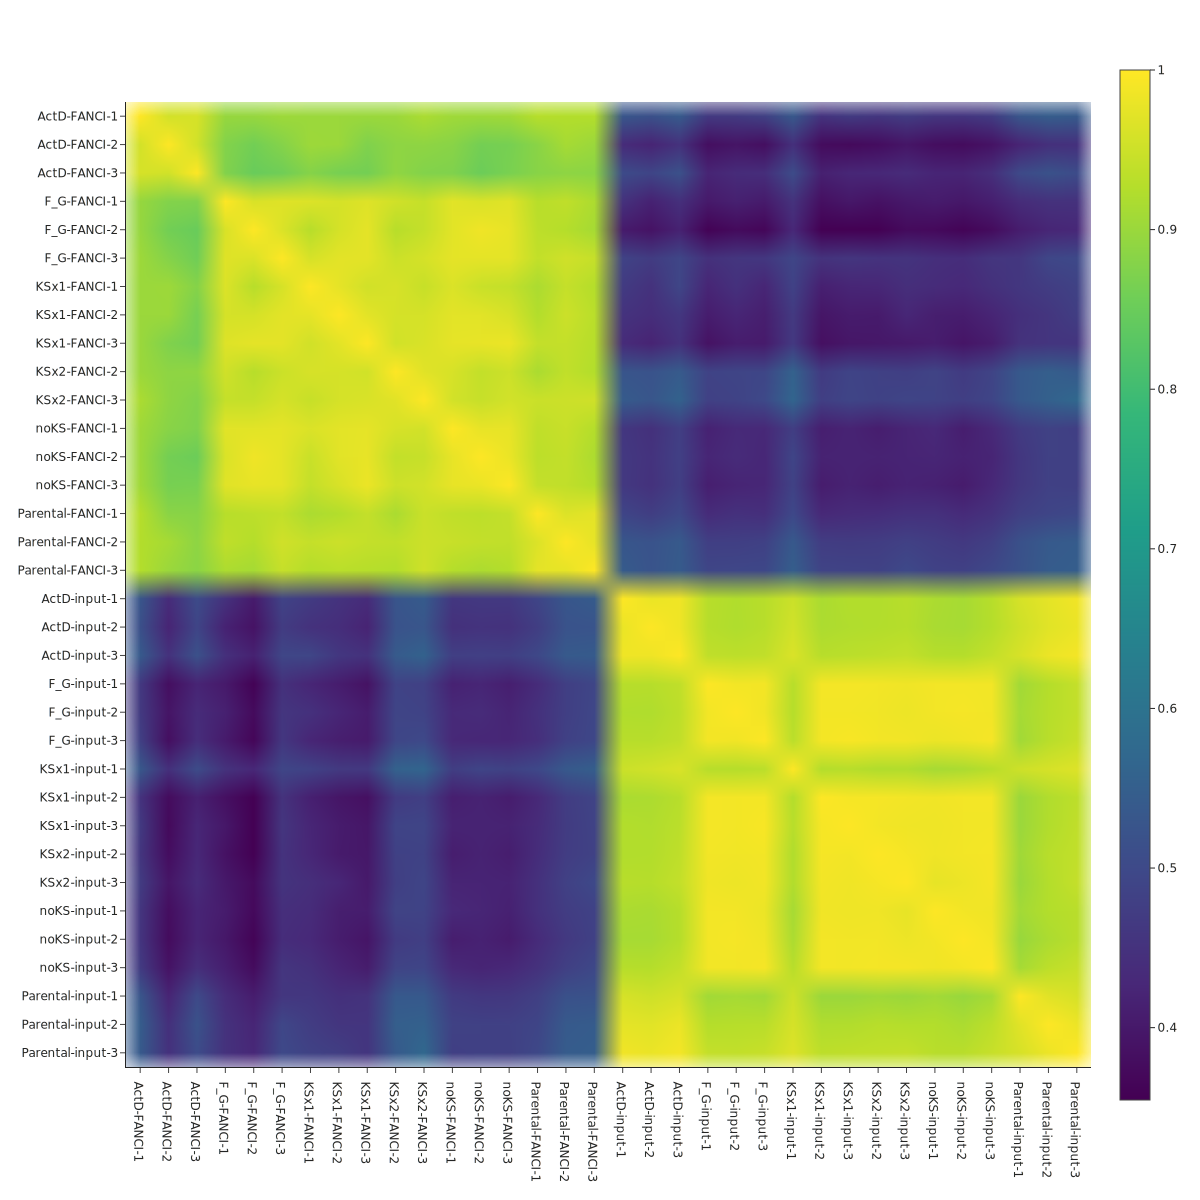

In [11]:
plot = ds.plot_correlation_matrix(method = "pearson")
plot.show(renderer = "svg", width=1200, height=1200)
plot.write_image("cluster_before_Norm.pdf")

In [6]:
start = time.time()
ds.reset_preprocessing()
#ds.mat.replace(0, np.nan, inplace=True)
ds.preprocess(
    subset = True,
    remove_contaminations=True,
    log2_transform =False,
    normalization = 'vst',
    imputation = None
)
from numpy import inf
ds.mat[ds.mat == -inf] = 0
end = time.time()

print(end - start)

All preprocessing steps are reset.
0.2516012191772461


In [118]:
import pickle 
with open('NucleolarProt_quantile_20241209.pickle', 'wb') as output:
    pickle.dump(ds, output)

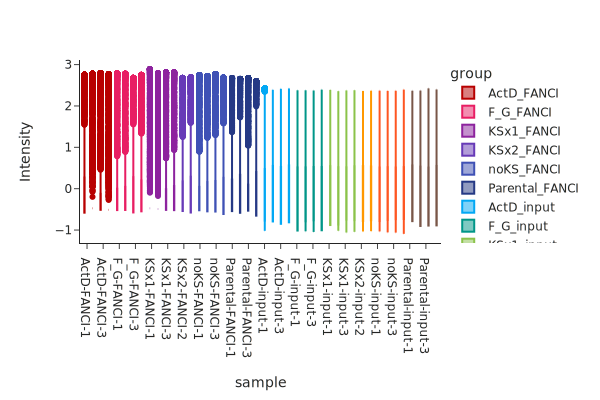

In [119]:
plot = ds.plot_sampledistribution(method = "box", color = "group", log_scale = False)
plot.show(renderer = "svg", width=600, height=400)
plot.write_image("sample_Dist_norm.pdf")

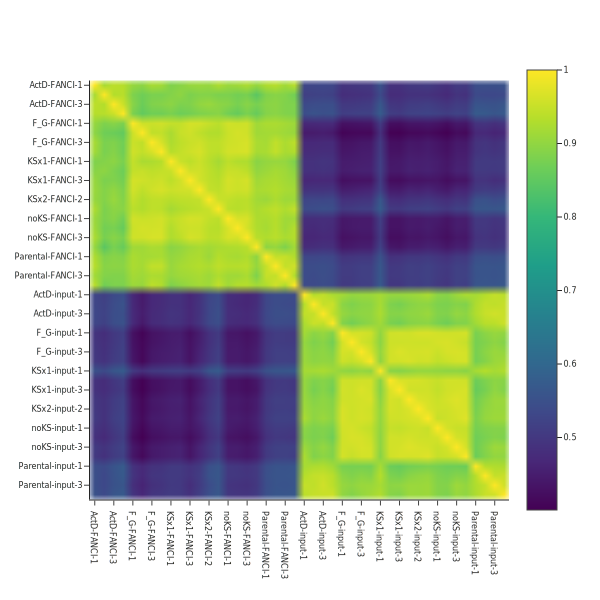

In [120]:
plot = ds.plot_correlation_matrix(method = "pearson")
plot.update_layout(font=dict(size=8))
plot.show(renderer = "svg", width=600, height=600)
plot.write_image("correlation_matrix_after_svd_quantile.pdf")

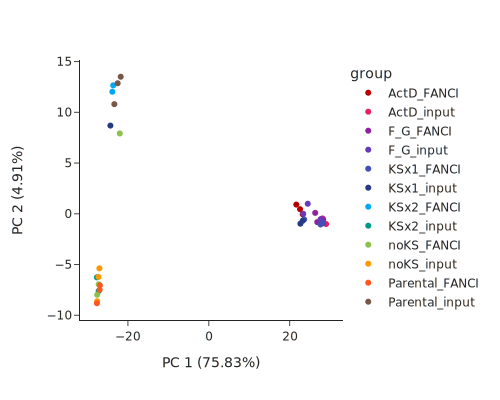

In [8]:
plot = ds.plot_pca(group = "group", circle = False)
plot.show(renderer = "svg", width=500, height=400, equal_axes=True)
plot.write_image("PCA_norm_all.pdf", width=500, height=400)

In [13]:
start = time.time()
ds.reset_preprocessing()
ds.rawmat = ds.rawmat + 1
#ds.mat.replace(0, np.nan, inplace=True)
ds.preprocess(
    subset = True,
    remove_contaminations=True,
    log2_transform =True,
    normalization = None,
    imputation = None
)
from numpy import inf
ds.mat[ds.mat == -inf] = 0
end = time.time()

print(end - start)

All preprocessing steps are reset.
Data has been log2-transformed.
0.053072214126586914


In [12]:
import plotly
from alphastats.plots.PlotUtils import PlotUtils, plotly_object
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import scipy
from scipy.spatial import distance
from scipy.cluster import hierarchy
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(12345)

In [124]:
def element_exists(lst, element):
  # Try to get the index of the element in the list
  try:
    lst.index(element)
  # If the element is found, return True
    return True
  # If a ValueError is raised, the element is not in the list
  except ValueError:
  # Return False in this case
    return False

In [125]:
# anova on ds to remove genes that dont change
anova_df = ds.anova(column="group", tukey=False)
# saev anova results
anova_df.to_csv('anova_df_Tukey_alphastats_processed_quantile_svd.csv', index=True)

# reset the index and use
anova_df = anova_df.set_index('Protein IDs')

# anova_df =  pd.read_csv('anova_df_Tukey_alphastats_processed_quantile_svd.csv',low_memory=False)
# significant_proteins = anova_df[anova_df["Protein IDs"]][ds.index_column].to_list()

In [126]:
# anova_df =  pd.read_csv('./Heatmap/anova_df_Tukey_alphastats_processed_quantile_svd.csv',low_memory=False).set_index('Protein IDs')
significant_proteins = anova_df[anova_df["ANOVA_pvalue"] < 0.05].index.to_list()
significant_proteins.append("mCherry") if "mCherry" not in significant_proteins else significant_proteins
significant_proteins_df = pd.DataFrame(significant_proteins, columns=["Protein IDs"]).to_csv('significat_proteins_anova.csv', index=False)

In [127]:
len(significant_proteins)

2369

In [14]:
df = ds.mat
df = pd.DataFrame(df).T
# set the desired order of groups
# groups = [ "Parental-input-1", "Parental-input-2", "Parental-input-3", "Parental-input-4",
#           "KSx1-input-1", "KSx1-input-2", "KSx1-input-3", "KSx1-input-4",
#           "KSx2-input-1", "KSx2-input-2", "KSx2-input-3", "KSx2-input-4",
#           "noKS-input-1", "noKS-input-2", "noKS-input-3", "noKS-input-4",
#           "F_G-input-1", "F_G-input-2", "F_G-input-3", "F_G-input-4",
#           "ActD-input-1", "ActD-input-2", "ActD-input-3", "ActD-input-4",
#           "Parental-FANCI-1", "Parental-FANCI-2", "Parental-FANCI-3", "Parental-FANCI-4",
#           "KSx1-FANCI-1", "KSx1-FANCI-2", "KSx1-FANCI-3", "KSx1-FANCI-4",
#           "KSx2-FANCI-1", "KSx2-FANCI-2", "KSx2-FANCI-3", "KSx2-FANCI-4",
#           "noKS-FANCI-1", "noKS-FANCI-2", "noKS-FANCI-3", "noKS-FANCI-4",
#           "F_G-FANCI-1", "F_G-FANCI-2", "F_G-FANCI-3", "F_G-FANCI-4", "ActD-FANCI-1",
#           "ActD-FANCI-2", "ActD-FANCI-3", "ActD-FANCI-4"
#           ]
groups = ["Parental-input-1", "Parental-input-2", "Parental-input-3",
          "noKS-input-1", "noKS-input-2", "noKS-input-3",
          "KSx1-input-1","KSx1-input-2", "KSx1-input-3",
          "KSx2-input-2", "KSx2-input-3",
          "F_G-input-1", "F_G-input-2", "F_G-input-3",

          "Parental-FANCI-1", "Parental-FANCI-2", "Parental-FANCI-3",
          "noKS-FANCI-1", "noKS-FANCI-2", "noKS-FANCI-3",
          "KSx1-FANCI-1","KSx1-FANCI-2", "KSx1-FANCI-3",
          "KSx2-FANCI-2", "KSx2-FANCI-3",
          "F_G-FANCI-1", "F_G-FANCI-2", "F_G-FANCI-3",
          
         ]



# reorder indexes/indices besed on the desired order
new_order = []
for group in groups:
    indexes = df.columns.str.startswith(group)
    indexes_locs = np.where(indexes)[0].tolist()
    new_order += indexes_locs

## reorder df based on the new order\
ordered_df = df.iloc[:, new_order]

#ordered_df = ordered_df.loc[ordered_df.index.isin(significant_proteins)]

In [15]:
print(df.shape)
print(ordered_df.shape)

(2963, 34)
(2963, 28)


In [16]:
ordered_df = ordered_df.reset_index()
ordered_df['Andersen2005'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in Andersen2005['Entry']))
ordered_df['SubCellBarcode'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments']=="N3"]['ProteinID']))
ordered_df['SubCellBarcode_N'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments'].isin(['N1','N2','N3', 'N4'])]['ProteinID']))
ordered_df['Stenstrom2020'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in set(Stenstrom2020['Uniprot ID'])))
ordered_df = ordered_df.set_index('Protein IDs')

In [17]:
ordered_df

,Parental-input-1,Parental-input-2,Parental-input-3,noKS-input-1,noKS-input-2,noKS-input-3,KSx1-input-1,KSx1-input-2,KSx1-input-3,KSx2-input-2,...,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3,Andersen2005,SubCellBarcode,SubCellBarcode_N,Stenstrom2020
Protein IDs,,,,,,,,,,,,,,,,,,,,,
Q9Y2S6;A0A024R1R8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.058499,0.000000,15.134827,0.000000,14.995988,15.129726,True,False,False,True
P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,16.127007,16.171724,16.302389,17.160541,17.135208,16.989483,16.418396,17.145992,17.123232,16.869305,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
A0AVT1;A0AVT1-2;A0AVT1-4;A0AVT1-3,0.000000,0.000000,0.000000,16.214755,0.000000,16.225829,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
A0FGR8;A0FGR8-2;A0FGR8-6;A0FGR8-5;A0FGR8-4,0.000000,14.710430,14.500655,14.183868,14.309263,14.261728,0.000000,14.435149,14.300996,14.402879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
A0MZ66;A0MZ66-3;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0MZ66-8;A0MZ66-2;A0MZ66-7,15.986131,16.281568,16.316688,16.525429,16.613818,16.518899,16.191657,16.625281,16.599680,16.617840,...,0.000000,13.876037,13.981032,13.482682,0.000000,0.000000,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Q9;Q9Y6Q9-5;Q9Y6Q9-4;Q9Y6Q9-2;Q9Y6Q9-3,0.000000,0.000000,0.000000,0.000000,0.000000,13.752799,0.000000,0.000000,13.723554,13.733121,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
Q9Y6V7,0.000000,14.943431,14.974639,14.707413,14.810270,14.855744,0.000000,14.709784,14.384042,14.685022,...,18.080047,17.515068,17.818158,17.949576,18.061023,17.900242,False,False,True,True
Q9Y6W5;Q9Y6W5-2;Q9UPY6;Q9UPY6-2,0.000000,14.702064,14.746357,14.566470,15.043924,14.765182,14.376193,14.627192,14.967632,14.954469,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False


In [18]:
print(ordered_df.Andersen2005.value_counts())
print(ordered_df.SubCellBarcode.value_counts())
print(ordered_df.Stenstrom2020.value_counts())
print(ordered_df.SubCellBarcode_N.value_counts())

Andersen2005
False    2370
True      593
Name: count, dtype: int64
SubCellBarcode
False    2793
True      170
Name: count, dtype: int64
Stenstrom2020
False    2572
True      391
Name: count, dtype: int64
SubCellBarcode_N
False    2470
True      493
Name: count, dtype: int64


In [19]:
def search(regex: str, df, case=False):
    """Search all the text columns of `df`, return rows with any matches."""
    textlikes = df.select_dtypes(include=[object, "string"])
    return df[
        textlikes.apply(
            lambda column: column.str.contains(regex, regex=True, case=case, na=False)
        ).any(axis=1)
    ]

In [20]:
Anderson2005_df = ordered_df.pop("Andersen2005")
SubCellBarcode_df = ordered_df.pop("SubCellBarcode")
SubCellBarcode_N_df = ordered_df.pop("SubCellBarcode_N")
Stenstrom2020_df = ordered_df.pop("Stenstrom2020")

In [136]:
ordered_df

,Parental-input-1,Parental-input-2,Parental-input-3,Parental-input-4,noKS-input-1,noKS-input-2,noKS-input-3,noKS-input-4,KSx1-input-1,KSx1-input-2,...,noKS-FANCI-4,KSx1-FANCI-1,KSx1-FANCI-2,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3,F_G-FANCI-4
Protein IDs,,,,,,,,,,,,,,,,,,,,,
Q9Y2S6;A0A024R1R8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.362680,0.000000,14.689507,15.058499,0.000000,15.134827,0.000000,14.995988,15.129726,15.115166
P0DPI2;A0A0B4J2D5;P0DPI2-2;A0A0B4J2D5-2,16.127007,16.171724,16.302389,16.043220,17.160541,17.135208,16.989483,17.278667,16.418396,17.145992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0AVT1;A0AVT1-2;A0AVT1-4;A0AVT1-3,0.000000,0.000000,0.000000,0.000000,16.214755,0.000000,16.225829,16.499581,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0FGR8;A0FGR8-2;A0FGR8-6;A0FGR8-5;A0FGR8-4,0.000000,14.710430,14.500655,14.459175,14.183868,14.309263,14.261728,14.143144,0.000000,14.435149,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0MZ66;A0MZ66-3;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0MZ66-8;A0MZ66-2;A0MZ66-7,15.986131,16.281568,16.316688,16.493652,16.525429,16.613818,16.518899,16.699139,16.191657,16.625281,...,12.764021,0.000000,0.000000,0.000000,13.876037,13.981032,13.482682,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Q9;Q9Y6Q9-5;Q9Y6Q9-4;Q9Y6Q9-2;Q9Y6Q9-3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.752799,13.800091,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q9Y6V7,0.000000,14.943431,14.974639,14.900206,14.707413,14.810270,14.855744,15.003474,0.000000,14.709784,...,17.388101,17.867315,17.996893,18.080047,17.515068,17.818158,17.949576,18.061023,17.900242,17.826685
Q9Y6W5;Q9Y6W5-2;Q9UPY6;Q9UPY6-2,0.000000,14.702064,14.746357,14.971364,14.566470,15.043924,14.765182,15.023235,14.376193,14.627192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
print(np.min(ordered_df))
print(np.max(ordered_df))
print(np.quantile(ordered_df, [0.1, 0.5, 0.95]))


0.0
24.018522134211906
[ 0.          0.         18.56395396]


In [138]:
SubCellBarcode_df.unique()

array([False,  True])

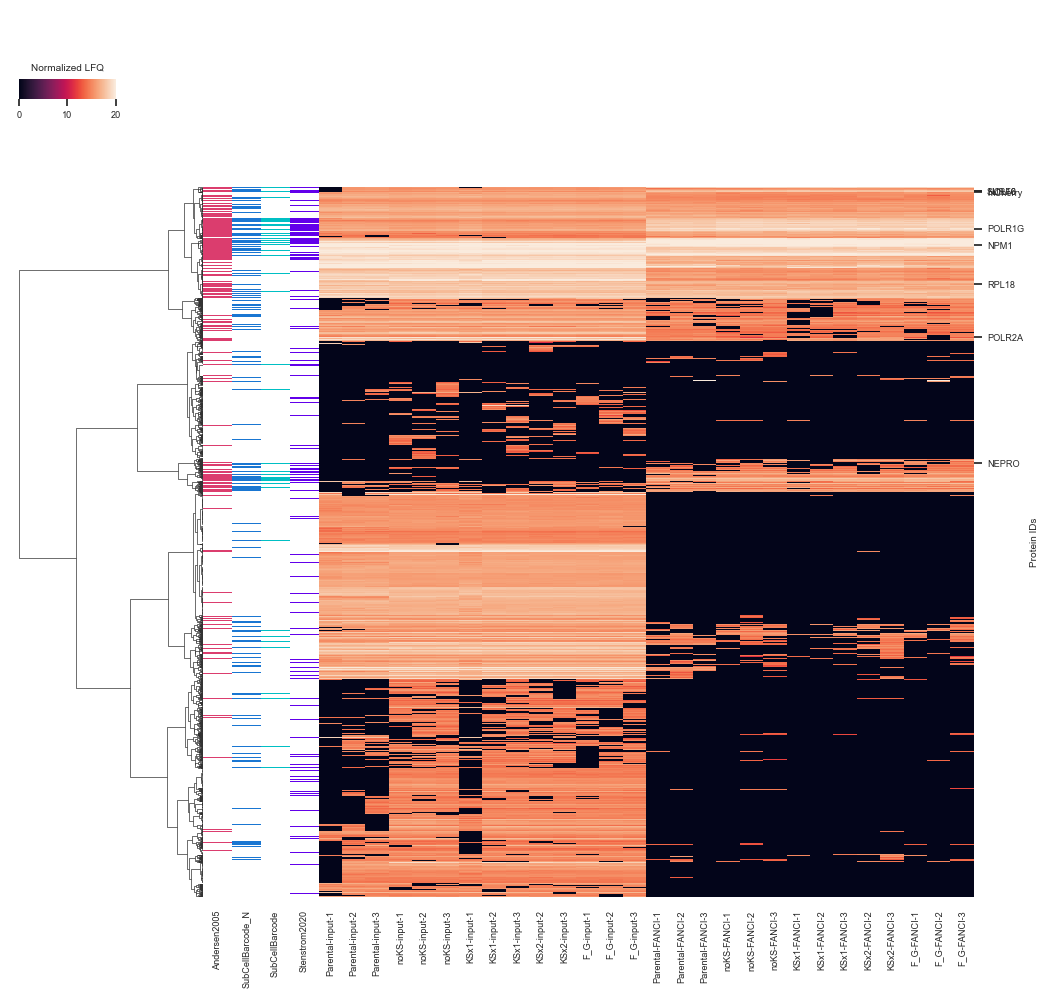

In [25]:
### Display some proteins

sns.set(font_scale=0.6)

lut1 = dict(zip(Anderson2005_df.unique(), ['#DB3D6E','#ffffff']))
row_colors1 = Anderson2005_df.map(lut1)

lut2 = dict(zip(SubCellBarcode_N_df.unique(), ['#ffffff','#1976D2']))
row_colors2 = SubCellBarcode_N_df.map(lut2)

lut3 = dict(zip(SubCellBarcode_df.unique(), ['#ffffff','#00BFC4']))
row_colors3 = SubCellBarcode_df.map(lut3)

lut4 = dict(zip(Stenstrom2020_df.unique(), ['#6200EA','#ffffff']))
row_colors4 = Stenstrom2020_df.map(lut4)

row_colors = pd.concat([row_colors1,row_colors2,row_colors3,row_colors4],axis=1)


heat_clust = sns.clustermap(ordered_df,
                            col_cluster=False,
                            yticklabels=False,
                            method='ward',
                            cmap="rocket",
                            row_colors=row_colors,
                            #cmap="coolwarm",
                            #cmap="icefire",
                            #cmap="RdPu",
                            #cmap="mako",
                            #cmap="YlGnBu",
                            #cmap=sns.diverging_palette(220, 20, as_cmap=True),
                            # cmap="RdYlBu",
                            # center=0,
                            #mask=(ordered_df==0),
                             vmin=0,
                             vmax=20,
                            cbar_kws=dict(
                                #ticks=[0,0.5, 1],
                                #ticks=[-2,0,1, 2],
                                orientation="horizontal",  
                            )
                           )

x0, _y0, _w, _h = heat_clust.cbar_pos
heat_clust.ax_cbar.set_position([x0,
                                 0.9,
                                 heat_clust.ax_row_dendrogram.get_position().width/2,
                                 0.02]
                               )
heat_clust.ax_cbar.set_title('Normalized LFQ')
heat_clust.ax_cbar.tick_params(axis='x',
                               length=5)

from matplotlib.pyplot import gcf


# #legend Anderson2005
# for label in Anderson2005_df.unique():
#     heat_clust.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)

# l1 = heat_clust.ax_col_dendrogram.legend(title='Anderson2005', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9), bbox_transform=gcf().transFigure)

# #legend SubCellBarcode_N
# for label in SubCellBarcode_N_df.unique():
#     heat_clust.ax_col_dendrogram.bar(0, 0, color=lut2[label], label=label, linewidth=0)

# l2 = heat_clust.ax_col_dendrogram.legend(title='SubCellBarcode_N', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9), bbox_transform=gcf().transFigure)

# #legend SubCellBarcode_N
# for label in SubCellBarcode_df.unique():
#     heat_clust.ax_col_dendrogram.bar(0, 0, color=lut3[label], label=label, linewidth=0)

# l3 = heat_clust.ax_col_dendrogram.legend(title='SubCellBarcode_N3', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9), bbox_transform=gcf().transFigure)


# #legend Stenstrom2020_df
# for label in Stenstrom2020_df.unique():
#     heat_clust.ax_col_dendrogram.bar(0, 0, color=lut4[label], label=label, linewidth=0)

# l4 = heat_clust.ax_col_dendrogram.legend(title='Stenstrom2020', loc="center", ncol=5, bbox_to_anchor=(0.9, 0.9), bbox_transform=gcf().transFigure)


reordered_labels = ordered_df.index[heat_clust.dendrogram_row.reordered_ind].tolist()
use_labels = []

use_labels = ['msfGFP-NPM1', 'mCherry',
              'Q6NW34', #NEPRO
              'Q9BSC4', #NOL10
              'O15446', #POLR1G
              'Q9P1U0', #POLR1H
              'P24928', #POLR2A
              'O75683', #SURF6
              'Q07020;Q07020-2' #RLP18
             ]

use_labels_correct = []
use_labels_g = []
use_labels_c = []
for labels in use_labels:
    use_labels_correct.append(search(labels, ds.rawinput, case=False)['Protein IDs'].values[0])

for labels in use_labels_correct:
    if labels in reordered_labels:
        use_labels_c.append(labels)
        use_labels_g.append(ds.rawinput.set_index('Protein IDs').loc[[labels], "Gene names"].values[0].split(";")[0])
    else: continue


use_ticks = [reordered_labels.index(label) + .5 for label in use_labels_c]

heat_clust.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels_g)

heat_clust.fig.set_size_inches((10,10))
heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_polimerase.pdf", format = 'pdf')
heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_polimerase.png", format = 'png', dpi = 300)

In [26]:
labels = heat_clust.ax_heatmap.yaxis.get_majorticklabels()
ordered_row_df_heat = heat_clust.data2d
row_order = heat_clust.data2d.index

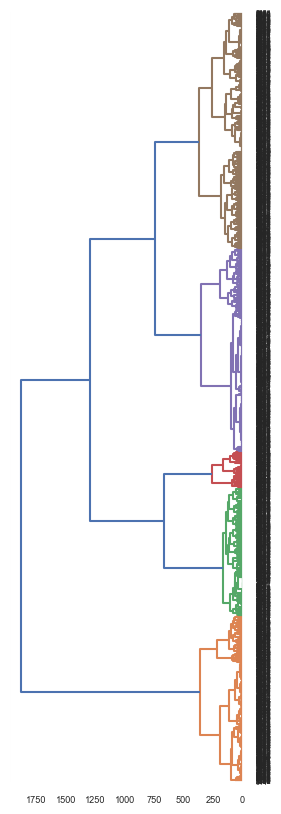

In [27]:
plt.figure(figsize=(3,10))
den = scipy.cluster.hierarchy.dendrogram(heat_clust.dendrogram_row.linkage,
                                         #labels = list(heat_clust.data2d.index),
                                         orientation='left',
                                         color_threshold = 500,
                                         get_leaves = True
                                         )

plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.png', format='png', bbox_inches='tight')
plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.pdf', format='pdf', bbox_inches='tight')

In [28]:
ordered_row_df = heat_clust.data2d
#extract ivl list (order of the dendrogram), leaves_color_list (cluster)
ordered_row_df.insert(0 , "cluster", den["leaves_color_list"])
ordered_row_df.insert(1 ,'order', np.arange(len(ordered_df)))
ordered_row_df.insert(2 , "original_index", den["ivl"])
ordered_row_df.head()

,cluster,order,original_index,Parental-input-1,Parental-input-2,Parental-input-3,noKS-input-1,noKS-input-2,noKS-input-3,KSx1-input-1,...,noKS-FANCI-2,noKS-FANCI-3,KSx1-FANCI-1,KSx1-FANCI-2,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3
Protein IDs,,,,,,,,,,,,,,,,,,,,,
P16403,C1,0,614,0.0,0.000000,21.502760,20.877101,0.000000,21.907566,0.000000,...,21.048599,21.805933,20.488856,21.283932,21.519702,20.873651,21.064540,20.876277,21.063026,21.310968
Q12788,C1,1,1392,0.0,15.664364,15.939212,15.653993,15.840680,15.698922,0.000000,...,19.012963,18.961919,18.686473,18.903658,19.111691,18.550784,18.813531,18.766684,19.180201,18.899681
Q9NQT5;Q9NQT5-2,C1,2,2568,0.0,17.195757,16.921260,16.603539,16.772753,16.785963,0.000000,...,18.061076,17.987486,17.975109,17.709676,17.936408,17.542533,17.700020,18.410427,17.969387,18.042333
Q6UX04;Q6UX04-2,C1,3,1810,0.0,14.662780,14.633960,14.902611,14.675681,15.051081,14.934152,...,14.777666,15.280735,15.137431,14.876613,14.998590,14.250150,14.964612,15.724647,14.753321,15.488123
Q9NQW6;Q9NQW6-2,C1,4,2569,0.0,15.255102,15.271901,14.741888,14.937834,15.016286,14.835360,...,14.426134,14.360298,14.934935,14.534972,14.502708,14.414091,14.624567,14.998238,14.619188,14.880253


In [29]:
ordered_row_df = ordered_row_df.reset_index()
ordered_row_df['Andersen2005'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in Andersen2005['Entry']))
ordered_row_df['SubCellBarcode'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments']=="N3"]['ProteinID']))
ordered_row_df['SubCellBarcode_N'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments'].isin(['N1','N2','N3', 'N4'])]['ProteinID']))
ordered_row_df['Stenstrom2020'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in set(Stenstrom2020['Uniprot ID'])))
ordered_row_df = ordered_row_df.set_index('Protein IDs')

In [30]:
ordered_row_df = pd.merge(ordered_row_df, ProteinGroups.set_index('Protein IDs').iloc[:, 0:11], left_index=True, right_index=True)

In [31]:
heat_clust.data2d['cluster'].unique()

array(['C1', 'C2', 'C3', 'C4', 'C5'], dtype=object)

In [32]:
ordered_row_df.to_csv('ordered_row_df_heatmap_wClustering_Total.csv', index=True)

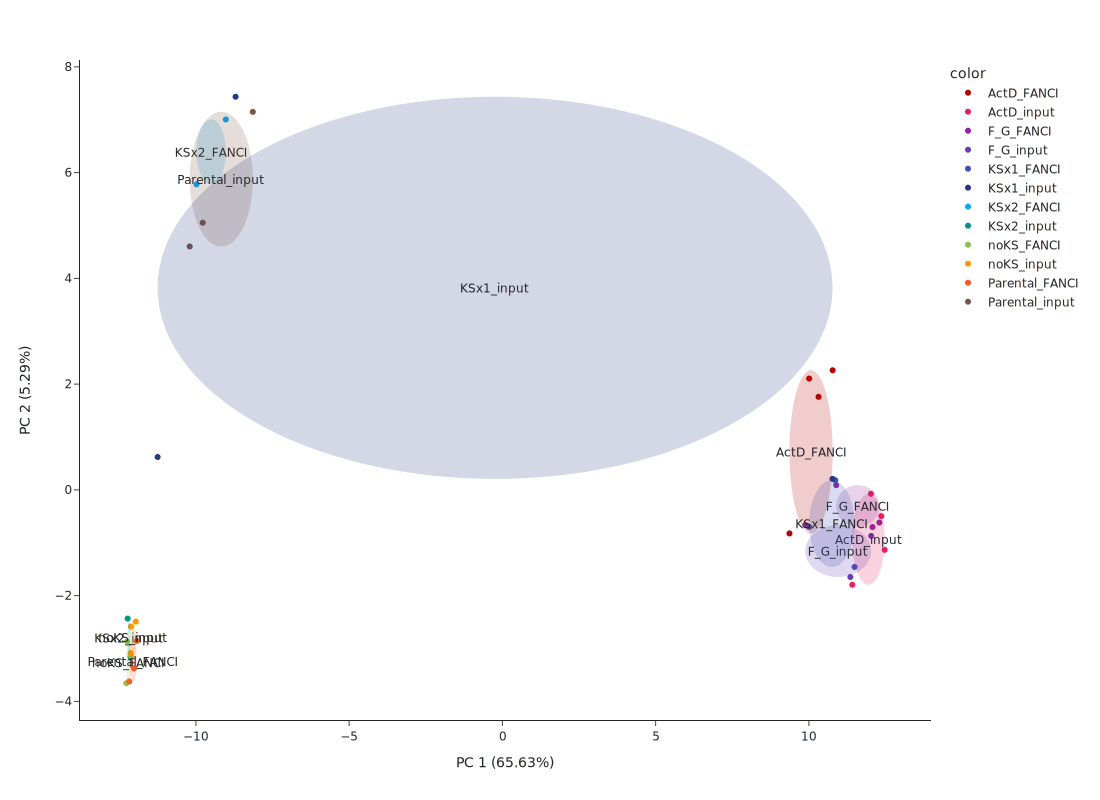